# Linear Regression from Scratch with Gradient Descent

In this tutorial, you will:

- Understand how Linear Regression works
- Implement it **from scratch** using Gradient Descent
- Visualize training progress (loss curves)
- Experiment with different learning rates
- See how predictions compare to actual values

We'll use the classic **Tips dataset** to predict tip amounts based on bill total and party size.

> **Note**: In practice, you would use `sklearn.linear_model.LinearRegression` which is faster and more robust. We're implementing gradient descent from scratch here to understand **how it works under the hood** — essential knowledge for understanding more complex models like neural networks.

## What is Linear Regression?

Linear Regression models the relationship between input features and a target variable as a linear equation:

```
y_pred = w1*x1 + w2*x2 + ... + wn*xn + b
```

Where:
- `x1, x2, ..., xn` are input features (e.g., total bill, party size)
- `w1, w2, ..., wn` are weights (parameters we learn)
- `b` is the bias term
- `y_pred` is our prediction (tip amount)

**Goal**: Find weights `w` and bias `b` that minimize the prediction error.

## What is Gradient Descent?

Gradient Descent is an optimization algorithm that finds the best parameters by iteratively moving in the direction that reduces the error.

**Analogy**: Imagine you're on a mountain in thick fog and want to reach the valley (lowest point). You can't see far, but you can feel which direction goes downhill. So you take small steps downhill, repeatedly, until you reach the bottom.

**The algorithm**:
1. Initialize weights (random values or zeros — for linear regression, both converge to the same solution)
2. Calculate predictions
3. Measure the error (how wrong we are)
4. Calculate gradients (which direction to adjust weights)
5. Update weights: `new_weight = old_weight - learning_rate * gradient`
6. Repeat until error stops decreasing

## Loss Function: Mean Squared Error (MSE)

We need a way to measure "how wrong" our predictions are. MSE is the most common choice:

```
MSE = (1/n) * sum((y_pred - y_actual)^2)
```

**Why squared?**
- Penalizes large errors more than small ones
- Mathematically smooth (easy to compute gradients)
- Always positive

---
## Step 1: Import Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

---
## Step 2: Load the Tips Dataset

The **Tips dataset** is a classic dataset included in seaborn. It contains information about restaurant bills and tips:

- `total_bill`: Total bill amount in dollars
- `tip`: Tip amount in dollars (our target)
- `sex`: Gender of the bill payer
- `smoker`: Whether the party included smokers
- `day`: Day of the week
- `time`: Lunch or Dinner
- `size`: Size of the party

We'll use `total_bill` and `size` to predict `tip`.

In [12]:
# Load the tips dataset from seaborn
tips = sns.load_dataset('tips')

print(f"Dataset shape: {tips.shape}")
tips.head(10)

Dataset shape: (244, 7)


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [13]:
# Check the data types and basic info
print("Column info:")
print(tips.dtypes)
print("\nMissing values:")
print(tips.isnull().sum())
print("\nBasic statistics:")
print(tips[['total_bill', 'tip', 'size']].describe())

Column info:
total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object

Missing values:
total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

Basic statistics:
       total_bill         tip        size
count  244.000000  244.000000  244.000000
mean    19.785943    2.998279    2.569672
std      8.902412    1.383638    0.951100
min      3.070000    1.000000    1.000000
25%     13.347500    2.000000    2.000000
50%     17.795000    2.900000    2.000000
75%     24.127500    3.562500    3.000000
max     50.810000   10.000000    6.000000


---
## Step 3: Data Preparation

The Tips dataset is already clean! No missing values, no outliers to remove.

We'll select our features and target:
- **Features**: `total_bill`, `size`
- **Target**: `tip`

Notice that all values are in similar ranges (single to double digits), which will make gradient descent work smoothly.

In [14]:
# Select features and target
features = ['total_bill', 'size']
target = 'tip'

print(f"Features: {features}")
print(f"Target: {target}")
print(f"\nFeature ranges:")
for f in features:
    print(f"  {f}: {tips[f].min():.1f} - {tips[f].max():.1f}")
print(f"\nTarget range:")
print(f"  {target}: {tips[target].min():.1f} - {tips[target].max():.1f}")

Features: ['total_bill', 'size']
Target: tip

Feature ranges:
  total_bill: 3.1 - 50.8
  size: 1.0 - 6.0

Target range:
  tip: 1.0 - 10.0


In [15]:
# Let's look at our data
print("Data summary:")
print(tips[features + [target]].describe())

Data summary:
       total_bill        size         tip
count  244.000000  244.000000  244.000000
mean    19.785943    2.569672    2.998279
std      8.902412    0.951100    1.383638
min      3.070000    1.000000    1.000000
25%     13.347500    2.000000    2.000000
50%     17.795000    2.000000    2.900000
75%     24.127500    3.000000    3.562500
max     50.810000    6.000000   10.000000


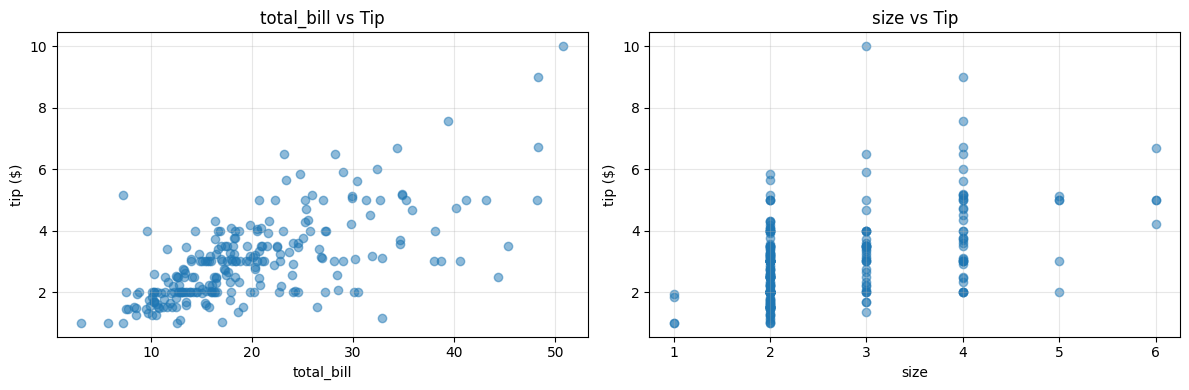

In [16]:
# Visualize relationships between features and tip
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, feature in enumerate(features):
    axes[i].scatter(tips[feature], tips[target], alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('tip ($)')
    axes[i].set_title(f'{feature} vs Tip')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Step 4: Prepare Features and Target

In [17]:
X = tips[features].values.astype(float)
y = tips[target].values.astype(float)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Features: {features}")
print(f"\nSample X (first 5 rows):")
print(X[:5])
print(f"\nSample y (first 5 values): {y[:5]}")

X shape: (244, 2)
y shape: (244,)
Features: ['total_bill', 'size']

Sample X (first 5 rows):
[[16.99  2.  ]
 [10.34  3.  ]
 [21.01  3.  ]
 [23.68  2.  ]
 [24.59  4.  ]]

Sample y (first 5 values): [1.01 1.66 3.5  3.31 3.61]


---
## Step 5: Split Data into Train and Validation Sets

We split our data into two parts:
- **Training set (80%)**: Used to train the model
- **Validation set (20%)**: Used to evaluate how well the model generalizes

**Why `random_state=42`?** The split is random — different runs would give different splits. Setting `random_state` to a fixed number (like 42) ensures **reproducibility**: you (and others) will get the exact same split every time. This is crucial for:
- Debugging (same results each run)
- Comparing experiments fairly
- Sharing reproducible tutorials

*Note: 42 is a common choice (a joke reference to "The Hitchhiker's Guide to the Galaxy"), but any integer works.*

In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set: 195 samples
Validation set: 49 samples


---
## Step 6: Implement Linear Regression from Scratch

Now let's implement our own Linear Regression class using gradient descent.

We'll implement **Batch Gradient Descent**, which uses the entire training set to compute gradients at each step. Other variants include:
- **Stochastic GD (SGD)**: Uses one sample at a time (noisy but fast)
- **Mini-batch GD**: Uses small batches (balance between the two)

### The Math Behind It

**Forward pass** (prediction):
```
y_pred = X @ w + b
```

**Loss** (MSE):
```
loss = mean((y_pred - y)^2)
```

**Gradients** (how to update weights):
```
dw = (2/n) * X.T @ (y_pred - y)
db = (2/n) * sum(y_pred - y)
```

**Update rule**:
```
w = w - learning_rate * dw
b = b - learning_rate * db
```

In [19]:
# TODO: Implement the LinearRegressionGD class
# Fill in the missing parts marked with TODO

class LinearRegressionGD:
    """
    Linear Regression using Gradient Descent.
    """

    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.diverged = False

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # TODO 1: Initialize weights and bias
        # weights should be zeros with shape (n_features,)
        # bias should be 0.0
        self.weights = np.zeros(n_features)  # Fix this
        self.bias = 0.0     # Fix this
        
        self.loss_history = []
        self.diverged = False

        for epoch in range(self.epochs):
            # TODO 2: Forward pass - compute predictions (see the formula in the description above)
            y_pred = np.dot(X, self.weights) + self.bias  # Fix this

            # TODO 3: Compute error (predictions - actual)
            error = y_pred - y  # Fix this

            # TODO 4: Compute MSE loss (see the formula in the description above)
            loss = np.mean(error ** 2)  # Fix this

            # Check for divergence
            if not np.isfinite(loss) or loss > 1e20:
                self.diverged = True
                break

            self.loss_history.append(loss)

            # TODO 5: Compute gradients (see the formulas in the description above)
            dw = (2 / n_samples) * np.dot(X.T, error)  # Fix this
            db = (2 / n_samples) * np.sum(error)  # Fix this

            # TODO 6: Update weights and bias
            # new = old - learning_rate * gradient
            self.weights -= self.learning_rate * dw  # Fix this
            self.bias -= self.learning_rate * db  # Fix this

        return self

    def predict(self, X):
        # TODO 7: Return predictions using learned weights (see the formula in the description above)
        return np.dot(X, self.weights) + self.bias  # Fix this

<details>
<summary><b>💡 Click for Hints</b></summary>

**TODO 1 - Initialize:**
```python
self.weights = np.zeros(n_features)
self.bias = 0.0
```

**TODO 2 - Forward pass:**
```python
y_pred = X @ self.weights + self.bias
```

**TODO 3 - Error:**
```python
error = y_pred - y
```

**TODO 4 - MSE Loss:**
```python
loss = np.mean(error ** 2)
```

**TODO 5 - Gradients:**
```python
dw = (2 / n_samples) * (X.T @ error)
db = (2 / n_samples) * np.sum(error)
```

**TODO 6 - Update:**
```python
self.weights -= self.learning_rate * dw
self.bias -= self.learning_rate * db
```

**TODO 7 - Predict:**
```python
return X @ self.weights + self.bias
```

</details>

<details>
<summary><b>✅ Click for Full Solution</b></summary>

```python
class LinearRegressionGD:
    """
    Linear Regression using Gradient Descent.
    """

    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.diverged = False

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0.0
        
        self.loss_history = []
        self.diverged = False

        for epoch in range(self.epochs):
            # Forward pass - compute predictions
            y_pred = X @ self.weights + self.bias

            # Compute error
            error = y_pred - y

            # Compute MSE loss
            loss = np.mean(error ** 2)

            # Check for divergence
            if not np.isfinite(loss) or loss > 1e20:
                self.diverged = True
                break

            self.loss_history.append(loss)

            # Compute gradients
            dw = (2 / n_samples) * (X.T @ error)
            db = (2 / n_samples) * np.sum(error)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

        return self

    def predict(self, X):
        return X @ self.weights + self.bias
```

</details>

---
## Step 7: Train the Model

Since `total_bill` can be up to ~50, the gradients can get large. We'll start with a conservative learning rate of 0.0001.

In [20]:
# Create and train the model
model = LinearRegressionGD(learning_rate=0.0001, epochs=50)
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Evaluate
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

print(f"Training MSE: {train_mse:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Training MAE: ${train_mae:.2f}")
print(f"Validation MAE: ${val_mae:.2f}")

Training MSE: 1.2755
Validation MSE: 0.7220
Training MAE: $0.79
Validation MAE: $0.67


---
## Step 8: Visualize Training Progress

One of the most important skills in ML is understanding how your model learns. Let's plot the loss curve.

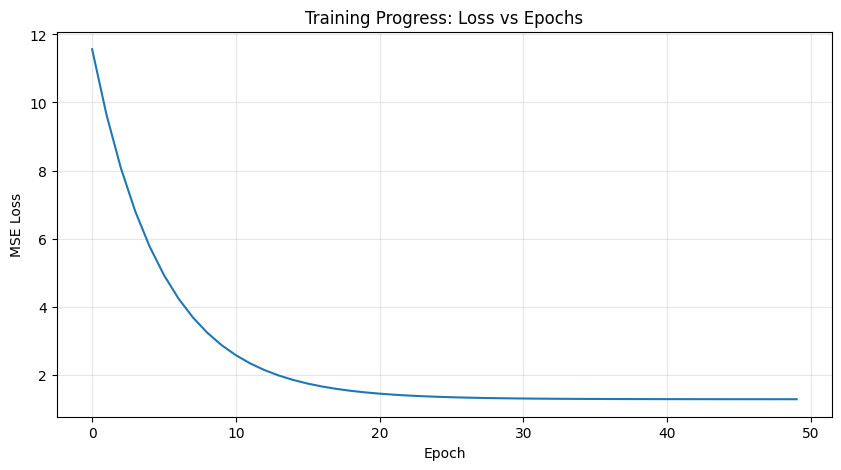

Initial loss: 11.5662
Final loss: 1.2756


In [21]:
plt.figure(figsize=(10, 5))
plt.plot(model.loss_history)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress: Loss vs Epochs')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Initial loss: {model.loss_history[0]:.4f}")
print(f"Final loss: {model.loss_history[-1]:.4f}")

### How to Read This Plot

- **Sharp drop at the beginning**: Model is learning quickly
- **Flattening curve**: Model is converging (found good weights)
- **If the curve goes UP or explodes to infinity**: Learning rate is too high!
- **If it decreases very slowly**: Learning rate might be too low (need more epochs)

---
## Step 9: Experiment with Learning Rates

The learning rate is one of the most important hyperparameters. Let's see how different values affect training.

lr=0.01: DIVERGED (loss exploded at epoch 11)


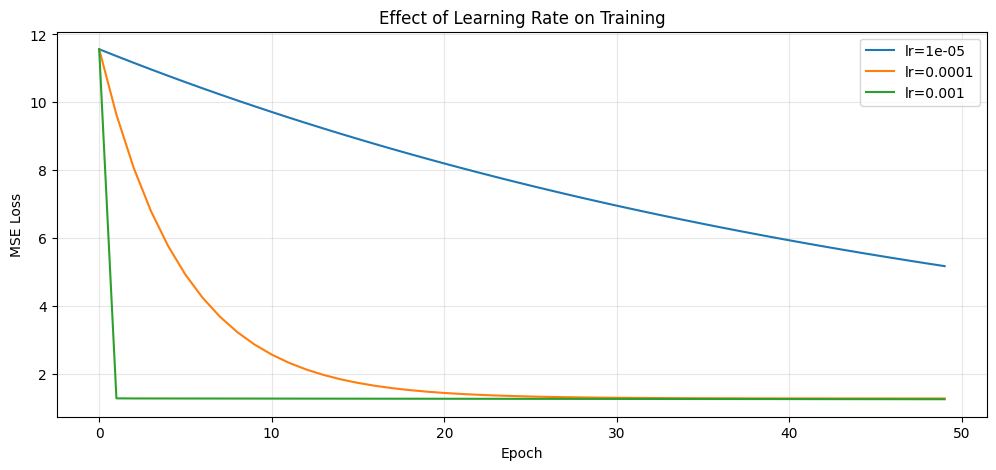

In [22]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01]

plt.figure(figsize=(12, 5))

for lr in learning_rates:
    model = LinearRegressionGD(learning_rate=lr, epochs=50)
    model.fit(X_train, y_train)

    # Only plot if model didn't diverge
    if model.diverged:
        print(f"lr={lr}: DIVERGED (loss exploded at epoch {len(model.loss_history)})")
    else:
        plt.plot(model.loss_history, label=f'lr={lr}')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Effect of Learning Rate on Training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### What Do You Observe?

- **Small learning rate (0.00001)**: Slow convergence, needs many more epochs
- **Good learning rate (0.0001-0.001)**: Reasonable convergence speed
- **Larger learning rate (0.002+)**: May oscillate or diverge

***Important***: Even with features on similar *relative* scales, values like `total_bill` (up to 50) amplify gradients. This is why feature scaling (normalizing to 0-1 range) is commonly used in practice.

---
## Step 10: Training Longer

Let's train for more epochs to see if the model continues to improve.

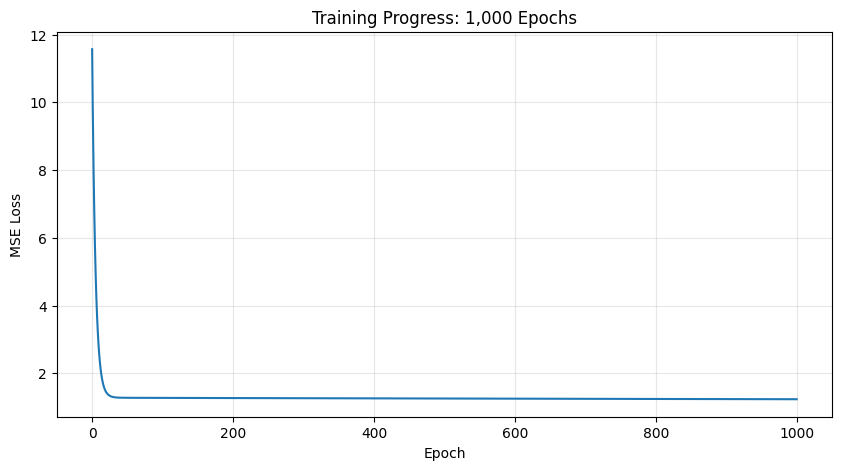

Final Validation MAE: $0.66


In [23]:
# Train for more epochs
model_long = LinearRegressionGD(learning_rate=0.0001, epochs=1000)
model_long.fit(X_train, y_train)

y_val_pred_long = model_long.predict(X_val)
val_mae_long = mean_absolute_error(y_val, y_val_pred_long)

plt.figure(figsize=(10, 5))
plt.plot(model_long.loss_history)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress: 1,000 Epochs')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Validation MAE: ${val_mae_long:.2f}")

---
## Step 11: Compare Different Learning Rates (Detailed)

In [24]:
learning_rates = [0.00001, 0.0001, 0.001, 0.002, 0.005]
results = {}

print("Learning Rate Comparison (2,000 epochs)")
print("=" * 50)

for lr in learning_rates:
    model = LinearRegressionGD(learning_rate=lr, epochs=2000)
    model.fit(X_train, y_train)

    # Check if model diverged
    if model.diverged:
        print(f"lr={lr}: DIVERGED (loss exploded)")
        results[lr] = {'mse': np.inf, 'mae': np.inf, 'diverged': True}
    else:
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        results[lr] = {'mse': val_mse, 'mae': val_mae, 'diverged': False}
        print(f"lr={lr}: Validation MAE = ${val_mae:.2f}")

# Find best learning rate
valid_results = {k: v for k, v in results.items() if not v['diverged']}
if valid_results:
    best_lr = min(valid_results, key=lambda x: valid_results[x]['mae'])
    print(f"\nBest learning rate: {best_lr}")

Learning Rate Comparison (2,000 epochs)
lr=1e-05: Validation MAE = $0.67
lr=0.0001: Validation MAE = $0.66
lr=0.001: Validation MAE = $0.68
lr=0.002: Validation MAE = $0.67
lr=0.005: DIVERGED (loss exploded)

Best learning rate: 0.0001


---
## Step 12: Predictions vs Actual Values

Let's visualize how well our model predicts tips.

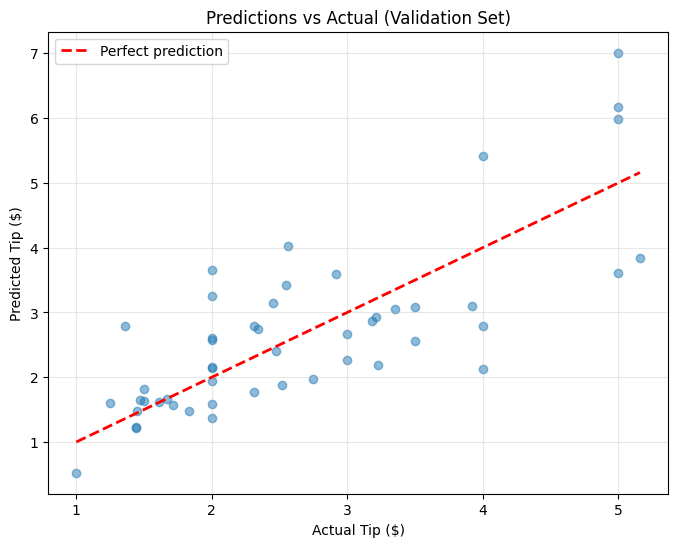

Final Validation MAE: $0.66


In [25]:
# Train final model with good settings (more epochs for convergence)
final_model = LinearRegressionGD(learning_rate=0.0001, epochs=1000)
final_model.fit(X_train, y_train)

y_val_pred = final_model.predict(X_val)

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Tip ($)')
plt.ylabel('Predicted Tip ($)')
plt.title('Predictions vs Actual (Validation Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

final_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Final Validation MAE: ${final_mae:.2f}")

### How to Read This Plot

- Points close to the red dashed line = good predictions
- Points far from the line = prediction errors
- If points form a diagonal pattern along the line, the model is working well

---
## Step 13: Examine the Learned Weights

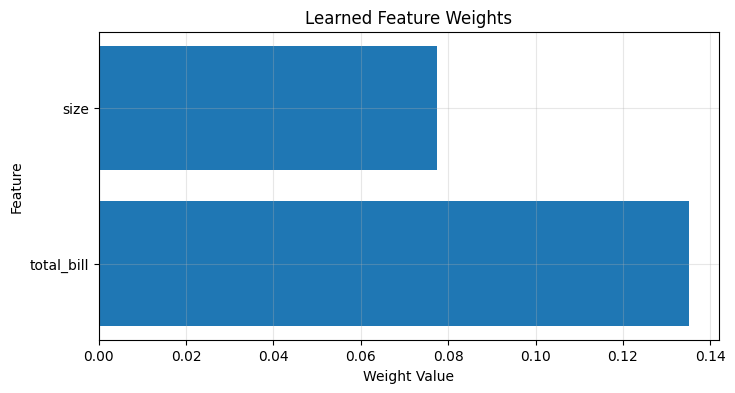


Feature weights:
  total_bill: 0.1352
  size: 0.0775

Bias: $0.03


In [26]:
# Show which features are most important
plt.figure(figsize=(8, 4))
plt.barh(features, final_model.weights)
plt.xlabel('Weight Value')
plt.ylabel('Feature')
plt.title('Learned Feature Weights')
plt.grid(True, alpha=0.3)
plt.show()

print("\nFeature weights:")
for name, weight in zip(features, final_model.weights):
    print(f"  {name}: {weight:.4f}")
print(f"\nBias: ${final_model.bias:.2f}")

### Interpreting Weights

- **total_bill weight**: For each additional dollar on the bill, the tip increases by this amount
- **size weight**: For each additional person in the party, the tip changes by this amount

---
## Step 14: Compare with Sklearn's Implementation

Let's verify our implementation works correctly by comparing with sklearn.

In [27]:
from sklearn.linear_model import LinearRegression

# Train sklearn model (uses closed-form solution, not gradient descent)
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)

# Compare predictions
sklearn_pred = sklearn_model.predict(X_val)
our_pred = final_model.predict(X_val)

sklearn_mae = mean_absolute_error(y_val, sklearn_pred)
our_mae = mean_absolute_error(y_val, our_pred)

print("Comparison: Our Model vs Sklearn")
print("=" * 40)
print(f"Our MAE:     ${our_mae:.2f}")
print(f"Sklearn MAE: ${sklearn_mae:.2f}")
print(f"\nDifference: ${abs(our_mae - sklearn_mae):.4f}")

Comparison: Our Model vs Sklearn
Our MAE:     $0.66
Sklearn MAE: $0.66

Difference: $0.0004


In [28]:
# Compare weights
print("\nWeight Comparison:")
print(f"{'Feature':<10} {'Our Model':>15} {'Sklearn':>15}")
print("-" * 42)
for name, our_w, sk_w in zip(features, final_model.weights, sklearn_model.coef_):
    print(f"{name:<10} {our_w:>15.4f} {sk_w:>15.4f}")
print(f"{'Bias':<10} {final_model.bias:>15.2f} {sklearn_model.intercept_:>15.2f}")


Weight Comparison:
Feature          Our Model         Sklearn
------------------------------------------
total_bill          0.1352          0.0909
size                0.0775          0.2650
Bias                  0.03            0.57


**Note**: Our weights may differ from sklearn because:
1. Sklearn uses a closed-form solution (exact), while we use gradient descent (approximate)
2. We may need more epochs or a different learning rate to fully converge

This is a key insight: **gradient descent is an approximation** that gets closer to the optimal solution with more iterations.

---
## TODO Exercises

Try these exercises to deepen your understanding:

### Exercise 1: What happens with a high learning rate?

Try `learning_rate=0.01` and observe what happens to the loss curve.

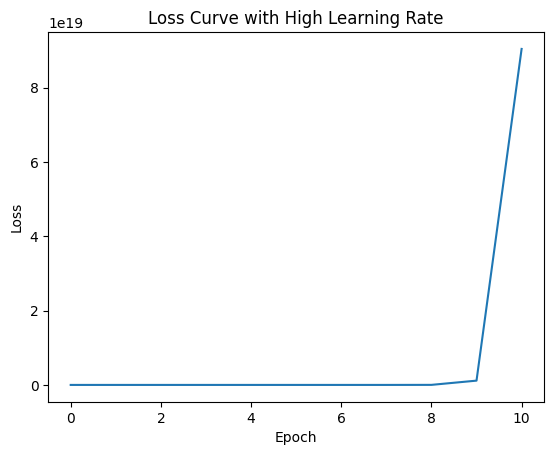

In [ ]:
# TODO: Train a model with learning_rate=0.01 and plot the loss curve
model_high_learning_rate = LinearRegressionGD(learning_rate=0.01, epochs=50)
model_high_learning_rate.fit(X_train, y_train)
# What do you observe?
#it seems to diverge, the loss explodes and becomes very large after a few epochs. 
# This is because the learning rate is too high.
# Your code here:
import matplotlib.pyplot as plt

plt.plot(model_high_learning_rate.loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve with High Learning Rate')
plt.show()

<details>
<summary><b>💡 Hints</b></summary>

1. Create a model with `LinearRegressionGD(learning_rate=0.01, epochs=100)`
2. Call `fit()` on the training data
3. Check if `model.diverged` is True - if so, the loss exploded
4. Plot `model.loss_history` to see what happened before divergence

</details>

<details>
<summary><b>✅ Solution</b></summary>

```python
# Train with high learning rate
model_high_lr = LinearRegressionGD(learning_rate=0.01, epochs=100)
model_high_lr.fit(X_train, y_train)

if model_high_lr.diverged:
    print(f"Model DIVERGED after {len(model_high_lr.loss_history)} epochs!")
    print("The learning rate is too high - gradients exploded.")
else:
    print("Model converged (surprising!)")

# Plot whatever history we have
if model_high_lr.loss_history:
    plt.figure(figsize=(10, 5))
    plt.plot(model_high_lr.loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training with lr=0.01 (Too High!)')
    plt.grid(True, alpha=0.3)
    plt.show()
```

**Expected result**: The model diverges quickly because lr=0.01 is too high for this data.

</details>

### Exercise 2: How many epochs do we really need?

With `learning_rate=0.0001`, experiment with different epoch counts (50, 100, 500, 1000, 2000). Plot the final MAE vs epochs.

In [34]:
# TODO: Experiment with different epoch values and plot MAE vs epochs
epoch_values = [50, 100, 500, 1000, 2000]
for epochs in epoch_values:
    model_short_epochs = LinearRegressionGD(learning_rate=0.0001, epochs=epochs)
    model_short_epochs.fit(X_train, y_train)

    y_val_pred_short = model_short_epochs.predict(X_val)
    val_mae_short = mean_absolute_error(y_val, y_val_pred_short)
    print(f"Validation MAE with {epochs} epochs: ${val_mae_short:.2f}")

Validation MAE with 50 epochs: $0.67
Validation MAE with 100 epochs: $0.67
Validation MAE with 500 epochs: $0.67
Validation MAE with 1000 epochs: $0.66
Validation MAE with 2000 epochs: $0.66


<details>
<summary><b>💡 Hints</b></summary>

1. Create a list of epoch values: `epoch_values = [50, 100, 500, 1000, 2000]`
2. Loop through each value, train a model, and compute validation MAE
3. Store results in a list
4. Use `plt.plot(epoch_values, mae_values)` to visualize

</details>

<details>
<summary><b>✅ Solution</b></summary>

```python
epoch_values = [50, 100, 500, 1000, 2000]
mae_values = []

for epochs in epoch_values:
    model = LinearRegressionGD(learning_rate=0.0001, epochs=epochs)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_val_pred)
    mae_values.append(mae)
    print(f"Epochs: {epochs:4d} -> MAE: ${mae:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(epoch_values, mae_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Epochs')
plt.ylabel('Validation MAE ($)')
plt.title('MAE vs Number of Epochs')
plt.grid(True, alpha=0.3)
plt.show()
```

**Expected observation**: MAE improves quickly at first, then plateaus. After ~500-1000 epochs, additional training provides diminishing returns.

</details>

### Exercise 3: Single Feature Model

Train a model using only `total_bill`. Visualize the regression line on a scatter plot.

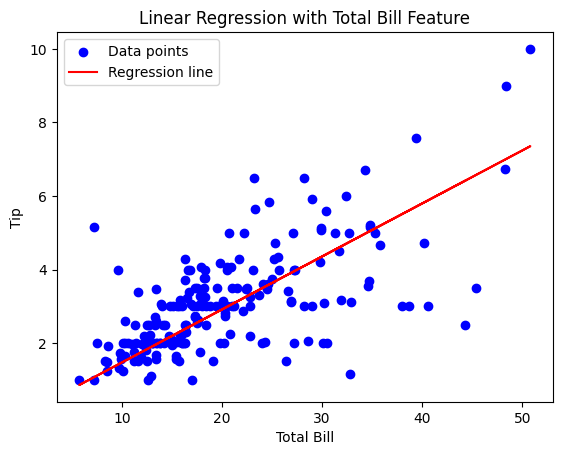

In [35]:
# TODO: Train a model with only total_bill feature and plot the regression line
# Hint: 
# 1. X_train_bill = X_train[:, 0:1]  # Keep 2D shape, just total_bill column
# 2. Train model
# 3. Create scatter plot of total_bill vs tip
# 4. Add regression line using model predictions

# Your code here:
X_train_bill = X_train[:, 0:1]
model_bill = LinearRegressionGD(learning_rate=0.0001, epochs=1000)
model_bill.fit(X_train_bill, y_train)

import matplotlib.pyplot as plt

plt.scatter(X_train_bill, y_train, color='blue', label='Data points')
plt.plot(X_train_bill, model_bill.predict(X_train_bill), color='red', label='Regression line')
plt.xlabel('Total Bill')
plt.ylabel('Tip')
plt.title('Linear Regression with Total Bill Feature')
plt.legend()
plt.show()

<details>
<summary><b>💡 Hints</b></summary>

1. Extract just the first column: `X_train_bill = X_train[:, 0:1]` (keep 2D shape!)
2. Do the same for validation: `X_val_bill = X_val[:, 0:1]`
3. Train the model on single-feature data
4. For the regression line, create a range of x values and predict y values
5. Use `plt.scatter()` for data points and `plt.plot()` for the line

</details>

<details>
<summary><b>✅ Solution</b></summary>

```python
# Extract just total_bill (keep 2D shape for the model)
X_train_bill = X_train[:, 0:1]
X_val_bill = X_val[:, 0:1]

# Train single-feature model
model_single = LinearRegressionGD(learning_rate=0.0001, epochs=1000)
model_single.fit(X_train_bill, y_train)

# Create regression line
x_line = np.linspace(X_train_bill.min(), X_train_bill.max(), 100).reshape(-1, 1)
y_line = model_single.predict(x_line)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train_bill, y_train, alpha=0.5, label='Training data')
plt.plot(x_line, y_line, 'r-', linewidth=2, label='Regression line')
plt.xlabel('Total Bill ($)')
plt.ylabel('Tip ($)')
plt.title('Single Feature Linear Regression: Total Bill vs Tip')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print model info
print(f"Weight (slope): {model_single.weights[0]:.4f}")
print(f"Bias (intercept): {model_single.bias:.4f}")
print(f"Interpretation: For every $1 increase in bill, tip increases by ${model_single.weights[0]:.2f}")
```

</details>

---
## Key Takeaways

1. **Linear Regression** models tip amounts as weighted sums of features (total_bill, size)

2. **Gradient Descent** iteratively adjusts weights to minimize the loss

3. **Learning Rate** controls step size:
   - Too small: Slow convergence, needs many epochs
   - Too large: May diverge (loss explodes to infinity)
   - Just right: Fast and stable convergence

4. **Feature Magnitude Affects Learning Rate**: Even with the Tips dataset where features are in similar *relative* ranges, `total_bill` values (up to 50) amplify gradients. This is why:
   - We needed a small learning rate (~0.0001)
   - **Feature scaling** (normalizing to 0-1 range) is commonly used to allow larger learning rates

5. **Loss Curves** help you understand training:
   - Decreasing curve: Model is learning
   - Flat curve: Model has converged
   - Increasing/exploding: Learning rate too high

6. **Gradient Descent vs Closed-Form**: Sklearn's LinearRegression uses a closed-form solution (exact answer), while gradient descent is iterative (approximate). With enough epochs, gradient descent converges to the same solution.